In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Importing the pre-processed version of the data and turning the target variable into a binary variable
df = pd.read_csv("preproc_data.csv")
df = df.iloc[:, 1:]
df['churn'] = df['churn'].map({'No': 0, 'Yes': 1})
df.describe(include='all')

,churn,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalintlcalls,totalintlcharge,numbercustomerservicecalls
count,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000
mean,0.136287,0.457745,0.905696,0.739873,0.159757,0.505552,0.500827,0.498255,0.494973,0.500983,0.494609,0.331994,0.503846,0.304536
std,0.343129,0.181672,0.292282,0.438750,0.279362,0.166457,0.168083,0.167155,0.166495,0.165245,0.166795,0.214228,0.160508,0.241370
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,1.000000,0.000000,0.000000,0.390718,0.387931,0.384615,0.381154,0.390203,0.384615,0.200000,0.397727,0.200000
50%,0.000000,0.458333,1.000000,1.000000,0.000000,0.503606,0.500000,0.504274,0.495865,0.501166,0.495726,0.300000,0.509091,0.200000
75%,0.000000,0.578704,1.000000,1.000000,0.333333,0.618140,0.612069,0.615385,0.605849,0.614878,0.606838,0.500000,0.613636,0.400000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Separating the dependent from the independent variables
X = df.drop('churn', axis=1).to_numpy()
y = df.loc[:, 'churn'].to_numpy()

Since our data has unbalanced classes, we will apply one of the techniques we saw on the pre-processing phase. For the SVM, since it depends heavily on the support vectors, it may be a good idea to do undersampling: reducing the data may lead to fairly equal results as oversampling, and in this case we reduce the training time for the model.

In [5]:
# Apply undersampling to the imbalanced class

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

count_no = np.sum(ytrain == 0)
count_yes = np.sum(ytrain == 1)
print(f"Array before: yes {count_yes}, no {count_no}")

# Apply RandomUnderSampler to address class imbalance
rus = RandomUnderSampler(random_state=42)
Xtrain, ytrain = rus.fit_resample(Xtrain, ytrain)

count_no = np.sum(ytrain == 0)
count_yes = np.sum(ytrain == 1)
print(f"Array after: yes {count_yes}, no {count_no}")


Array before: yes 519, no 3273
Array after: yes 519, no 519


We created a function that will evaluate the final models that we will choose.

In [6]:
def evaluate(model, model_name):
    predictions = model.predict(Xtest)

    cm = metrics.confusion_matrix(ytest, predictions)

    ConfusionMatrixDisplay.from_estimator(model, Xtest, ytest)
    plt.show()

    tp = cm[1][1]
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    total = tp + tn + fp + fn
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)

    print(f"{model_name} Kernel SVM:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    print(f"Accuracy: {(tp+tn)/total}")
    print(f"Error: {1-(tp+tn)/total}")
    print(f"Recall: {recall}")
    print(f"Specificity: {tn/(tn+fp)}")
    print(f"Precision: {precision}")
    print(f"F1: {2*recall*precision/(recall+precision)}")


Next, we will do hyperparameter tuning using a validation set with 10-fold cross-validation.
We will choose 2 models, one for the best f1-score, and after that one for the best overall accuracy.

In [7]:
def cvSVMC(n, div, scoring):
    kernels = ['linear', 'poly', 'rbf']

    fig, axs = plt.subplots(3, 1, figsize=(8, 6))
    
    index = 0
    for kernel in kernels:
        recalls = [0] * (n-1)
        std = [0] * (n-1)
        list = [*range(1, n)]
        cValues = [x/div for x in list]
        j = 0
        for i in cValues:
            svm = SVC(kernel=kernel, C=i)
            scores=cross_val_score(svm, Xtrain, ytrain, cv=10, scoring=scoring)

            std[j] = scores.std()
            recalls[j] = scores.mean()
            j+=1

        axs[index].plot(cValues, recalls, label=kernel)
        axs[index].set_ylabel(f'{scoring}')
        axs[index].set_title(f'{kernel}')
        index+=1
    
    axs[-1].set_xlabel('C')
    fig.suptitle(f'Relation between hyperparameter C and {scoring} for different kernels')
    plt.tight_layout()
    plt.show()

    #plt.scatter(cValues, recalls)

    

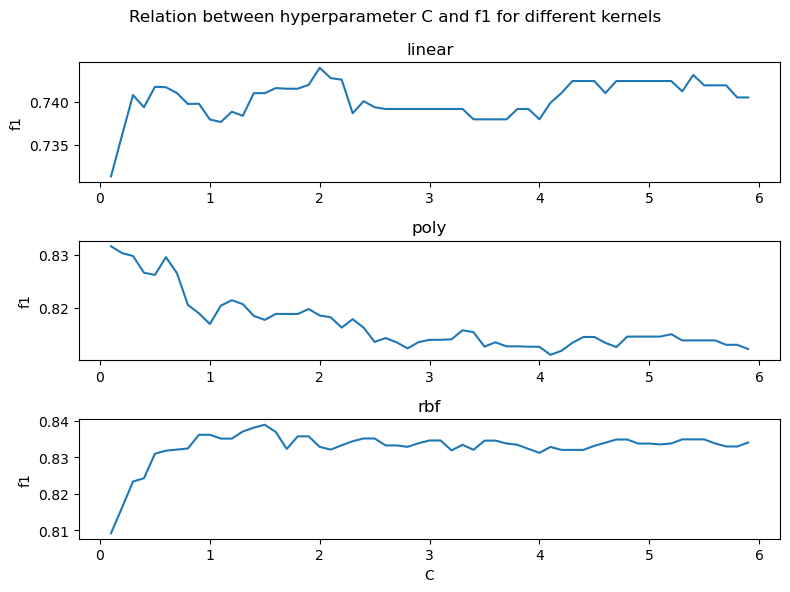

In [17]:
cvSVMC(n=60, div=10, scoring='f1')

Aside from small variances, after C=1.5 the values for the f1-score with linear kernel stay relatively the same, with a bit of a drop after C=2.

For the polynomial kernel, we have high values of recall for small values of C, which may indicate overfitting. After C=2, the values for the recall decrease, a possible sign of underfitting. An adequate value would be around 1.5.

The RBF Kernel seems to have good values for the f1-score for C around 1.5, and it stays the same after C = 2. Therefore, adequate values would be greater than 1 and smaller than 2. We can also see that the overall f1-score is the highest for this kernel. Choosing the rbf kernel with C=1.5 seems like a viable choice. Now we will try to choose an adequate value for the gamma hyperparameter.

In [48]:
def cvSVMGamma(kernel, n, div, scoring):
    recalls = [0] * (n-1)
    std = [0] * (n-1)
    list = [*range(1, n)]
    cValues = [x/div for x in list]
    j = 0
    for i in cValues:
        svm = SVC(kernel=kernel, C=1.5, gamma=i)
        scores=cross_val_score(svm, Xtrain, ytrain, cv=10, scoring=scoring)

        std[j] = scores.std()
        recalls[j] = scores.mean()
        j+=1

    print(f"Standard Deviations: {std}")
    plt.scatter(cValues, recalls)

    plt.xlabel('C')
    plt.ylabel('Recall')

    plt.title(f'Relation between hyperparameter gamma and {scoring} for {kernel}')
    plt.show()

Standard Deviations: [0.03438314189600558, 0.028093444088862777, 0.021366183775124375, 0.025765892047077108, 0.025073340580811915, 0.028137756133346226, 0.027686724896890814, 0.02713667283884145, 0.028374725324161854, 0.030828630866805977, 0.031815628072209584, 0.03356964884177966, 0.031803819948045674, 0.027059154594296426, 0.029015047141183182, 0.027007136626834325, 0.02244772006989163, 0.024372039811094395, 0.024800677368059826, 0.02593068765120215, 0.03083833815107294, 0.03139978649551258, 0.031055637021491524, 0.031045306477395968, 0.031774359067493846, 0.032187225778509736, 0.030458271338323097, 0.02961445221470014, 0.030732052801102618, 0.030732052801102618, 0.030316220592360523, 0.030316220592360523, 0.027877389401571886, 0.025910659514614083, 0.026920755802774483, 0.026920755802774483, 0.026412682526800728, 0.027126067748218397, 0.027473199199200483]


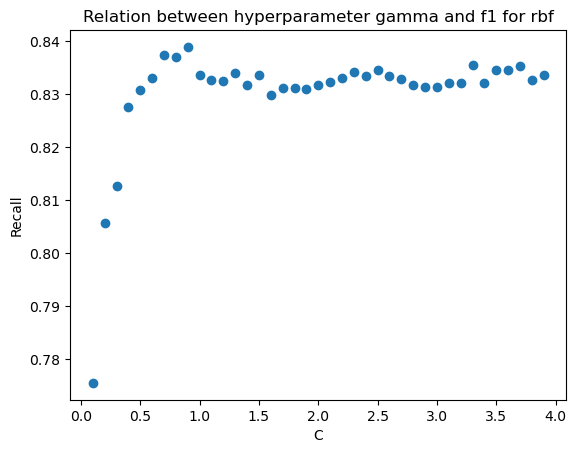

In [49]:
cvSVMGamma('rbf', 40, 10, 'f1')

We can see that after gamma=1, the f1-score stays relatively equal. We will choose gamma=1 as our hyperparameter.
The best model we found for the SVM in terms of f1-score has the following hyperparameters: RBF kernel, 1.5 for C and 1 for gamma. Now we will train this model in the full training set and test it on the test set.

In [50]:
# Best Results for F1: kernel='rbf', C=1.5, gamma=1

svmRBF = SVC(kernel='rbf', C=1.5, gamma=1)
svmRBF.fit(Xtrain, ytrain)

SVC(C=1.5, gamma=1)

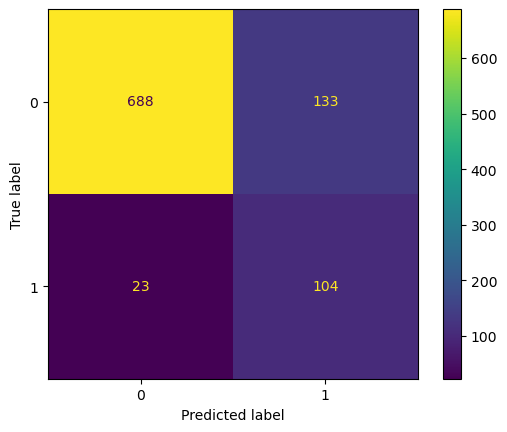

RBF Kernel SVM:
TP: 104, TN: 688, FP: 133, FN: 23
Accuracy: 0.8354430379746836
Error: 0.16455696202531644
Recall: 0.8188976377952756
Specificity: 0.8380024360535931
Precision: 0.4388185654008439
F1: 0.5714285714285715


In [51]:
evaluate(svmRBF, 'RBF')

Finally testing the model with all the hyperparameters chosen, we get an accuracy of 84% and an f1-score of 57%.
The accuracy is decent, but the F1-Score is not. It may be the case that the rbf kernel is not able to make a linear separation of this dataset, and other kernels may even be better. It does seem, however, that for the tested kernels (and hyperparameters), this is the best option. We will now build a model for the best possible accuracy.

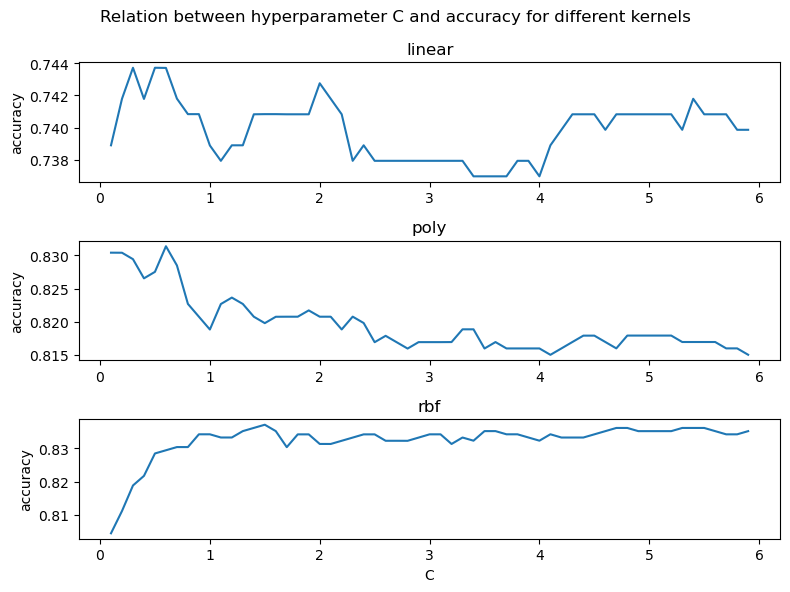

In [18]:
cvSVMC(n=60, div=10, scoring='accuracy')

The values for the accuracy using linear kernel are very disperse, and overall not good.

For the polynomial kernel, there seems to be some overfitting for small values of C. After C=0.8, the values stay the same until C = 2.5, where it decreases, indicating signs of underfitting. The best values for C for the polynomial Kernel would be between 1 and 2.

The RBF kernel shows poor results for small C values, and it stays around the same after C = 1. An adequate value would be 1.5. Again, these are the same hyperparameters chosen for the best model for the f1-score. We will now choose a good value for the gamma hyperparameter.

Standard Deviations: [0.03126197362418608, 0.026988170711709378, 0.021647255669492892, 0.026621172916843107, 0.02708895738944102, 0.028926502474460266, 0.02935650357534896, 0.02871971541726635, 0.029693966226421797, 0.031809554778755834, 0.03330829784763587, 0.034478059428454236, 0.031856440141139086, 0.027104454625055365, 0.028328489005329496, 0.027008243586954427, 0.022855927742686813, 0.024881651368171998, 0.02597248443234342, 0.027355912393440148, 0.03246254358594287, 0.033275943258873265, 0.03259624355786875, 0.03265553349955125, 0.03349520417193363, 0.03416203558456795, 0.03224268230147003, 0.03137278810244885, 0.03224477021320234, 0.03224477021320234, 0.03130259157047257, 0.03130259157047257, 0.028338406953284486, 0.025570543744660442, 0.0269214325091154, 0.0269214325091154, 0.026044755007332537, 0.026209697238122835, 0.026451909468772638]


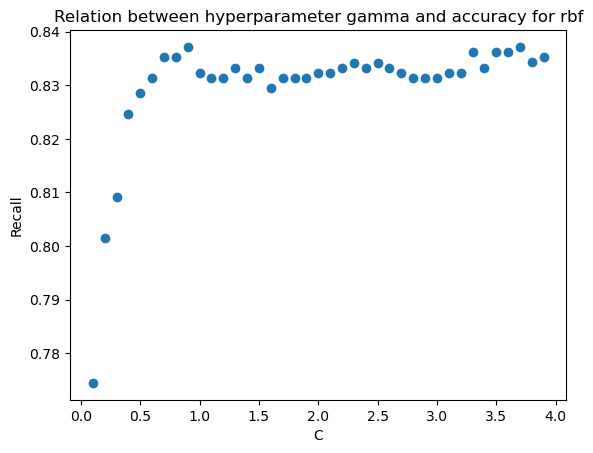

In [53]:
cvSVMGamma('rbf', 40, 10, 'accuracy')

It seems like the accuracy increases from gamma=0 to 0.7, and then it stays around the same. We will choose 0.7 as an adequate value for the gamma hyperparameter. The best model we found for the SVM in terms of its accuracy has the following hyperparameters: RBF kernel, 1.5 for C and 0.7 for gamma. Now we will train this model in the full training set and test it on the test set.

In [54]:
#Best Results for Acc: Kernel = RBF, C = 1.5, Gamma = 0.7

svmRBF = SVC(kernel='rbf', C=1.5, gamma=0.7)
svmRBF.fit(Xtrain, ytrain)

SVC(C=1.5, gamma=0.7)

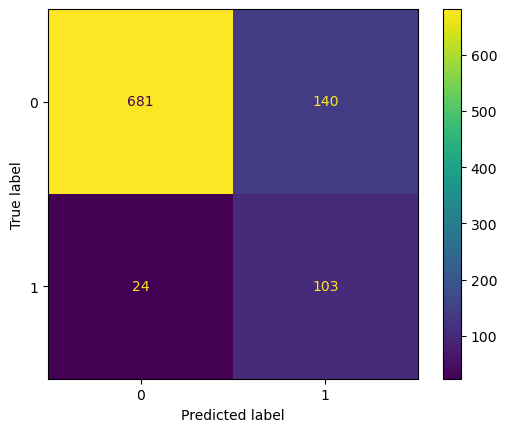

RBF Kernel SVM:
TP: 103, TN: 681, FP: 140, FN: 24
Accuracy: 0.8270042194092827
Error: 0.1729957805907173
Recall: 0.8110236220472441
Specificity: 0.8294762484774665
Precision: 0.42386831275720166
F1: 0.5567567567567567


In [55]:
evaluate(svmRBF, 'RBF')

We can see that the overall accuracy of the model was not very high, staying around 82%. This indicates that the svm may not be the indicated model to be used for this dataset. This may be because none of the used kernels can disperse the data in a way that creates a linear separation.